## 8.1 Problem Framing

Following exploratory data analysis and hypothesis testing, multiple machine learning formulations were explored to model the relationship between job market demand and public interest. The initial approach treated the problem as a regression task, aiming to predict absolute Google Trends interest using job posting counts. However, despite applying logarithmic transformations to address skewness and stabilize scale differences, regression models exhibited limited explanatory power under Leave-One-Out Cross Validation.

To further address scale imbalance, an alternative target formulation based on relative interest—defined as the difference between log-transformed search interest and log-transformed job postings—was evaluated. This normalization aimed to capture whether certain roles were disproportionately searched relative to their market size. Nevertheless, this formulation also failed to produce stable or meaningful predictive performance, suggesting that continuous-valued regression targets were not well suited to the available data.

Based on these findings, the problem was reformulated as a binary classification task. Rather than predicting exact interest levels, the final objective became distinguishing between high-interest and low-interest roles. This reframing better aligns with the limited sample size and the ordinal nature of public interest data, enabling more robust and interpretable modeling outcomes.


## 2. Feature and Target Definition

The feature set consists of the logarithmically transformed job posting counts, which mitigates skewness and stabilizes scale differences across roles. The target variable was defined as a binary indicator representing whether a role’s Google Trends interest exceeds the median value. This thresholding strategy resulted in balanced class distributions, which is particularly suitable for small-sample classification tasks.


## 3. Model Choice and Preprocessing

Logistic regression was selected as the primary classification model due to its interpretability and robustness in small datasets. A preprocessing pipeline incorporating feature standardization was employed to ensure consistent scaling across cross-validation folds. To address potential class imbalance, balanced class weights were used. All modeling steps were integrated within a unified pipeline to prevent data leakage.


## 4. Model Evaluation Strategy

Model performance was evaluated using Leave-One-Out Cross Validation (LOOCV), which maximizes training data usage while providing an unbiased estimate of generalization performance. LOOCV is particularly well-suited for small datasets, as it allows each observation to serve as a test instance exactly once.


## 5. Model Performance

Using the LOOCV framework, the logistic regression model achieved an accuracy of 0.75 and a ROC-AUC score of 0.65. These results indicate that the model performs substantially better than random guessing and is able to meaningfully discriminate between high-interest and low-interest roles. The confusion matrix further reveals balanced predictive performance across both classes.


## 6. Model Interpretation

The estimated coefficient for the logarithm of job posting counts was positive, indicating that roles with higher market demand are more likely to exhibit elevated public interest. This finding aligns closely with the earlier Spearman correlation analysis, demonstrating consistency between traditional statistical testing and machine learning-based modeling.


## 7. Robustness Analysis

Robustness checks were conducted to assess the stability of the classification results. A dummy baseline classifier yielded near-random performance, while the logistic regression model consistently outperformed this baseline. Sensitivity analysis across different regularization strengths showed minimal variation in accuracy, suggesting that the model’s performance is not driven by specific parameter choices.


## 8. Limitations and Future Work

This study is subject to several limitations. The dataset consists of a small number of aggregated observations, limiting the complexity of models that can be reliably applied. Additionally, public interest measured via Google Trends may be influenced by external factors not captured in the current feature set. Future work may incorporate temporal dynamics, expand the feature space with role-specific attributes, or explore alternative formulations such as ranking-based or multi-class models.


# Project Setup Notes

This notebook requires the following two input files to be present in the working directory before execution:

- `google_trends_it_jobs_totals.csv`  
  Contains aggregated Google Trends interest values for IT-related job roles.

- `it_role_group_counts.csv`  
  Contains job posting counts per IT role group.  
  The dataset has been preprocessed to exclude the `other it` category to ensure consistent role matching.

Both files are generated or curated during the data preparation phase and are assumed to be available prior to running this notebook.


In [1]:
import pandas as pd
trends_df = pd.read_csv("google_trends_it_jobs_totals.csv")
counts_df = pd.read_csv("it_role_group_counts.csv")
print(trends_df.head())
print(counts_df.head())


               job_group          search_term  total_trends_interest
0      backend developer   back end developer                    121
1  business analyst (it)  it business analyst                    388
2         cloud engineer       cloud engineer                    773
3           data analyst         data analyst                   6129
4         data scientist       data scientist                   2663
           it_role_group  count
0      software engineer   3579
1   project manager (it)   2085
2         data scientist    889
3  it support specialist    834
4  business analyst (it)    744


In [2]:
final_df = pd.merge(
    trends_df,
    counts_df,
    left_on="job_group",
    right_on="it_role_group",
    how="inner"
)
final_df = final_df.drop(columns=["it_role_group"])
print(final_df.shape)
print(final_df.columns)




(20, 4)
Index(['job_group', 'search_term', 'total_trends_interest', 'count'], dtype='object')


In [3]:
missing_in_counts = set(trends_df["job_group"]) - set(counts_df["it_role_group"])
missing_in_trends = set(counts_df["it_role_group"]) - set(trends_df["job_group"])

print("Counts tarafında eksik olanlar:", missing_in_counts)
print("Trends tarafında eksik olanlar:", missing_in_trends)


Counts tarafında eksik olanlar: set()
Trends tarafında eksik olanlar: set()


In [4]:
final_df.sort_values("total_trends_interest", ascending=False)


,job_group,search_term,total_trends_interest,count
3,data analyst,data analyst,6129,488
13,network / systems administrator,system administrator,5858,554
14,product manager (tech),product manager,5706,659
18,software engineer,software engineer,5381,3579
16,qa engineer,qa engineer,3237,573
4,data scientist,data scientist,2663,889
19,ux / ui designer,ux designer,2651,198
5,database administrator,database administrator,2296,225
17,security engineer,cyber security engineer,1450,539
7,engineering manager / tech lead,engineering manager,1407,729


In [5]:
df_ml = final_df.copy()
X_baseline = df_ml[["count"]]
y_baseline = df_ml["total_trends_interest"]
print(X_baseline.shape)
print(y_baseline.shape)


(20, 1)
(20,)


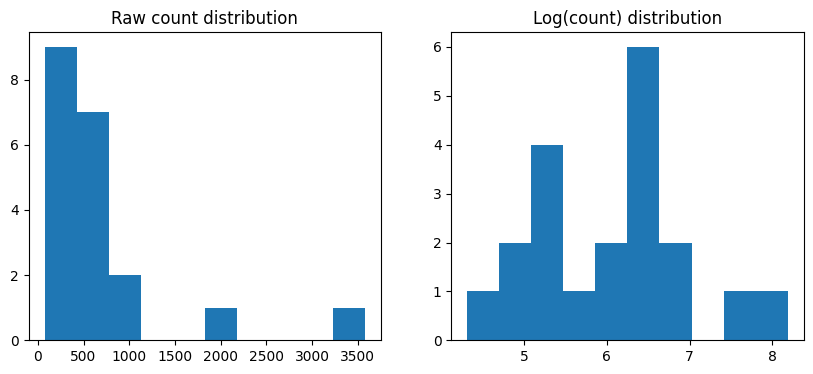

In [6]:
import numpy as np

df_ml["log_count"] = np.log1p(df_ml["count"])
df_ml["log_trends"] = np.log1p(df_ml["total_trends_interest"])
X_log = df_ml[["log_count"]]
y_log = df_ml["log_trends"]
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(df_ml["count"], bins=10)
axes[0].set_title("Raw count distribution")

axes[1].hist(df_ml["log_count"], bins=10)
axes[1].set_title("Log(count) distribution")

plt.show()


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
ridge_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])
lasso_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", Lasso(alpha=0.1, max_iter=10000))
])
print(ridge_pipe)
print(lasso_pipe)

# Candidate feature-target sets
feature_sets = {
    "baseline": (X_baseline, y_baseline),
    "log": (X_log, y_log)
}



Pipeline(steps=[('scaler', StandardScaler()), ('model', Ridge())])
Pipeline(steps=[('scaler', StandardScaler()),
                ('model', Lasso(alpha=0.1, max_iter=10000))])


In [11]:
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
loo = LeaveOneOut()
def loocv_evaluate(model, X, y):
    y_true = []
    y_pred = []

    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        y_true.append(y_test.values[0])
        y_pred.append(pred[0])

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    return y_true, y_pred, mae, rmse, r2


In [12]:
y_true_rb, y_pred_rb, mae_rb, rmse_rb, r2_rb = loocv_evaluate(
    ridge_pipe, X_baseline, y_baseline
)
y_true_lb, y_pred_lb, mae_lb, rmse_lb, r2_lb = loocv_evaluate(
    lasso_pipe, X_baseline, y_baseline
)
y_true_rl, y_pred_rl, mae_rl, rmse_rl, r2_rl = loocv_evaluate(
    ridge_pipe, X_log, y_log
)
y_true_ll, y_pred_ll, mae_ll, rmse_ll, r2_ll = loocv_evaluate(
    lasso_pipe, X_log, y_log
)
print("=== BASELINE FEATURES ===")
print(f"Ridge  | MAE: {mae_rb:.2f}, RMSE: {rmse_rb:.2f}, R2: {r2_rb:.3f}")
print(f"Lasso  | MAE: {mae_lb:.2f}, RMSE: {rmse_lb:.2f}, R2: {r2_lb:.3f}")

print("\n=== LOG-TRANSFORMED FEATURES ===")
print(f"Ridge  | MAE: {mae_rl:.2f}, RMSE: {rmse_rl:.2f}, R2: {r2_rl:.3f}")
print(f"Lasso  | MAE: {mae_ll:.2f}, RMSE: {rmse_ll:.2f}, R2: {r2_ll:.3f}")



=== BASELINE FEATURES ===
Ridge  | MAE: 1747.43, RMSE: 2106.63, R2: -0.093
Lasso  | MAE: 1745.76, RMSE: 2109.43, R2: -0.096

=== LOG-TRANSFORMED FEATURES ===
Ridge  | MAE: 0.91, RMSE: 1.13, R2: 0.146
Lasso  | MAE: 0.93, RMSE: 1.14, R2: 0.131


In [13]:
import numpy as np

df_rel = final_df.copy()

# log versions (already created before olabilir; yoksa burada garantili oluşturuyoruz)
df_rel["log_trends"] = np.log1p(df_rel["total_trends_interest"])
df_rel["log_count"]  = np.log1p(df_rel["count"])

# NEW TARGET: relative interest
df_rel["relative_interest"] = df_rel["log_trends"] - df_rel["log_count"]

# Feature (X) - burada iki opsiyon var. Ben log_count öneriyorum.
X_rel = df_rel[["log_count"]]
y_rel = df_rel["relative_interest"]

df_rel[["job_group", "count", "total_trends_interest", "relative_interest"]].sort_values(
    "relative_interest", ascending=False
).head(10)


,job_group,count,total_trends_interest,relative_interest
19,ux / ui designer,198,2651,2.589765
3,data analyst,488,6129,2.528588
13,network / systems administrator,554,5858,2.356766
5,database administrator,225,2296,2.318824
14,product manager (tech),659,5706,2.157209
16,qa engineer,573,3237,1.730082
9,full stack developer,231,1100,1.557237
8,frontend developer,199,724,1.287854
4,data scientist,889,2663,1.096363
11,machine learning engineer,110,319,1.058791


In [14]:
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

loo = LeaveOneOut()

def loocv_evaluate(model, X, y):
    y_true, y_pred = [], []

    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)
        pred = model.predict(X_test)

        y_true.append(y_test.values[0])
        y_pred.append(pred[0])

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)

    return y_true, y_pred, mae, rmse, r2


In [15]:
y_true_rr, y_pred_rr, mae_rr, rmse_rr, r2_rr = loocv_evaluate(ridge_pipe, X_rel, y_rel)
y_true_lr, y_pred_lr, mae_lr, rmse_lr, r2_lr = loocv_evaluate(lasso_pipe, X_rel, y_rel)

print("=== RELATIVE INTEREST TARGET (log(trends) - log(count)) ===")
print(f"Ridge | MAE: {mae_rr:.3f}, RMSE: {rmse_rr:.3f}, R2: {r2_rr:.3f}")
print(f"Lasso | MAE: {mae_lr:.3f}, RMSE: {rmse_lr:.3f}, R2: {r2_lr:.3f}")


=== RELATIVE INTEREST TARGET (log(trends) - log(count)) ===
Ridge | MAE: 0.918, RMSE: 1.130, R2: -0.200
Lasso | MAE: 0.925, RMSE: 1.130, R2: -0.201


In [16]:
# Eski log-log sonuçlarını tekrar hesapla (zaten hesapladıysan bu kısmı atlayabilirsin)
y_true_old, y_pred_old, mae_old, rmse_old, r2_old = loocv_evaluate(ridge_pipe, X_log, y_log)

print("\n=== COMPARISON (Ridge) ===")
print(f"Old target: log_trends      | MAE: {mae_old:.3f}, RMSE: {rmse_old:.3f}, R2: {r2_old:.3f}")
print(f"New target: relative_interest | MAE: {mae_rr:.3f}, RMSE: {rmse_rr:.3f}, R2: {r2_rr:.3f}")



=== COMPARISON (Ridge) ===
Old target: log_trends      | MAE: 0.914, RMSE: 1.131, R2: 0.146
New target: relative_interest | MAE: 0.918, RMSE: 1.130, R2: -0.200


In [17]:
import numpy as np

df_cls = final_df.copy()

# Binary target: High (1) vs Low (0) interest
median_trends = df_cls["total_trends_interest"].median()

df_cls["high_interest"] = (df_cls["total_trends_interest"] > median_trends).astype(int)

df_cls[["job_group", "total_trends_interest", "high_interest"]].sort_values(
    "total_trends_interest", ascending=False
)
df_cls["high_interest"].value_counts()


,count
high_interest,
0,10
1,10


In [18]:
X_cls = np.log1p(df_cls[["count"]])
y_cls = df_cls["high_interest"]
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

logreg_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        class_weight="balanced",
        solver="liblinear",
        random_state=42
    ))
])


In [19]:
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

loo = LeaveOneOut()

y_true, y_pred, y_prob = [], [], []

for train_idx, test_idx in loo.split(X_cls):
    X_train, X_test = X_cls.iloc[train_idx], X_cls.iloc[test_idx]
    y_train, y_test = y_cls.iloc[train_idx], y_cls.iloc[test_idx]

    logreg_pipe.fit(X_train, y_train)

    pred = logreg_pipe.predict(X_test)
    prob = logreg_pipe.predict_proba(X_test)[:, 1]

    y_true.append(y_test.values[0])
    y_pred.append(pred[0])
    y_prob.append(prob[0])

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)


In [20]:
acc = accuracy_score(y_true, y_pred)
roc = roc_auc_score(y_true, y_prob)
cm  = confusion_matrix(y_true, y_pred)

print("=== LOGISTIC REGRESSION (LOOCV) ===")
print(f"Accuracy : {acc:.3f}")
print(f"ROC-AUC  : {roc:.3f}")
print("Confusion Matrix:")
print(cm)


=== LOGISTIC REGRESSION (LOOCV) ===
Accuracy : 0.750
ROC-AUC  : 0.650
Confusion Matrix:
[[7 3]
 [2 8]]


In [21]:
logreg_pipe.fit(X_cls, y_cls)

coef = logreg_pipe.named_steps["model"].coef_[0][0]
print(f"Coefficient for log(count): {coef:.3f}")


Coefficient for log(count): 0.634


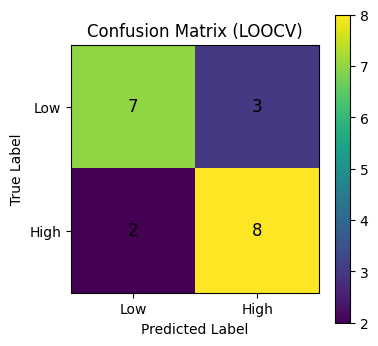

In [22]:
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4, 4))
plt.imshow(cm)
plt.colorbar()

plt.xticks([0, 1], ["Low", "High"])
plt.yticks([0, 1], ["Low", "High"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=12)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (LOOCV)")
plt.show()


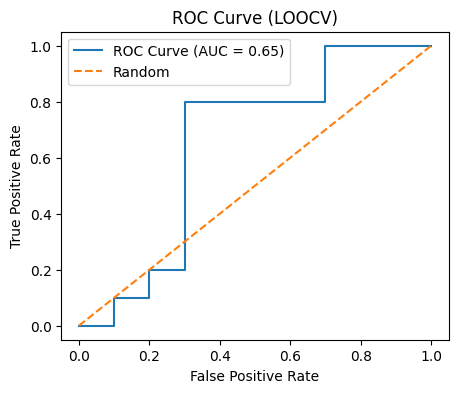

In [23]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (LOOCV)")
plt.legend()
plt.show()


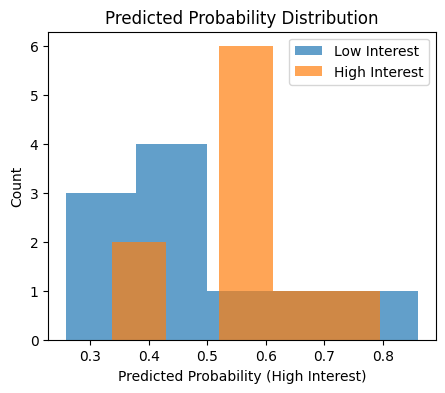

In [24]:
plt.figure(figsize=(5, 4))
plt.hist(y_prob[y_true == 0], bins=5, alpha=0.7, label="Low Interest")
plt.hist(y_prob[y_true == 1], bins=5, alpha=0.7, label="High Interest")

plt.xlabel("Predicted Probability (High Interest)")
plt.ylabel("Count")
plt.title("Predicted Probability Distribution")
plt.legend()
plt.show()


In [29]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy = DummyClassifier(strategy="most_frequent")

dummy.fit(X_cls, y_cls)
y_pred_dummy = dummy.predict(X_cls)

baseline_acc = accuracy_score(y_cls, y_pred_dummy)

print("=== BASELINE (DUMMY CLASSIFIER) ===")
print(f"Accuracy: {baseline_acc:.3f}")


=== BASELINE (DUMMY CLASSIFIER) ===
Accuracy: 0.500


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

print("=== REGULARIZATION SENSITIVITY (C PARAMETER) ===")

for C in [0.1, 1.0, 10.0]:
    logreg_tmp = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            C=C,
            class_weight="balanced",
            solver="liblinear",
            random_state=42
        ))
    ])

    y_true_c, y_pred_c = [], []

    for train_idx, test_idx in loo.split(X_cls):
        X_train, X_test = X_cls.iloc[train_idx], X_cls.iloc[test_idx]
        y_train, y_test = y_cls.iloc[train_idx], y_cls.iloc[test_idx]

        logreg_tmp.fit(X_train, y_train)
        pred = logreg_tmp.predict(X_test)

        y_true_c.append(y_test.values[0])
        y_pred_c.append(pred[0])

    acc_c = accuracy_score(y_true_c, y_pred_c)
    print(f"C = {C:<4} → LOOCV Accuracy = {acc_c:.3f}")


=== REGULARIZATION SENSITIVITY (C PARAMETER) ===
C = 0.1  → LOOCV Accuracy = 0.750
C = 1.0  → LOOCV Accuracy = 0.750
C = 10.0 → LOOCV Accuracy = 0.750


In [31]:
upper_tercile = df_cls["total_trends_interest"].quantile(0.67)

df_cls["high_interest_upper"] = (df_cls["total_trends_interest"] > upper_tercile).astype(int)

y_upper = df_cls["high_interest_upper"]

print("Class distribution (upper tercile):")
print(y_upper.value_counts())


Class distribution (upper tercile):
high_interest_upper
0    13
1     7
Name: count, dtype: int64


In [32]:
y_true_u, y_pred_u = [], []

for train_idx, test_idx in loo.split(X_cls):
    X_train, X_test = X_cls.iloc[train_idx], X_cls.iloc[test_idx]
    y_train, y_test = y_upper.iloc[train_idx], y_upper.iloc[test_idx]

    logreg_pipe.fit(X_train, y_train)
    pred = logreg_pipe.predict(X_test)

    y_true_u.append(y_test.values[0])
    y_pred_u.append(pred[0])

acc_upper = accuracy_score(y_true_u, y_pred_u)

print("Upper tercile LOOCV Accuracy:", round(acc_upper, 3))


Upper tercile LOOCV Accuracy: 0.7
